In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import yfinance as yf
import datetime

from valueinvesting import utils as utils

# 1. Load raw input
## Hardcoded block

In [2]:
evaluate_last_X_years = True
X=10
currency_pair = 'EUR=X'
numbers_in_currency = 'EUR'
share_name = 'NDA.DE'

# 1.1 Calculate Share numbers from total distributed dividend (CFS) and dividend amount

# 1.2. Raw input statement data

In [3]:
route = f"../data/input/{share_name}_data.csv"
data = pd.read_csv(route, sep=';', parse_dates=['date', 'real_date'])
# replace -, extend missing 0-s, fix datatype
data = utils.replace_format_input(data)

In [4]:
owned_shares = pd.read_csv('../data/extras/owned_stocks.csv', sep=';', parse_dates=['date'])
owned_shares = owned_shares.loc[(owned_shares['stock'] == share_name) & (owned_shares['active'] == 'yes')]

## (OPTIONAL) Time Filtering - Last 7 years daat

In [5]:
if evaluate_last_X_years:
    data = data[data['date'] > datetime.datetime.today() - datetime.timedelta(days=X*366+93)]
    data = data.reset_index(drop=True)

data.head()

,date,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,curr_assets,goodwill,...,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,shares,real_date
0,2014-12-31,2635,-2516,118,25,254,207,1931,2518,0,...,883,0,151,1261,305,2115,102,-21,44.96,2015-02-14
1,2015-03-31,2884,-2660,224,106,296,430,1813,2758,0,...,893,0,45,1249,530,2353,7,-26,44.96,2015-05-10
2,2015-06-30,2948,-2794,154,51,479,404,1816,2871,0,...,954,0,20,1289,510,2330,239,-22,44.96,2015-08-09
3,2015-09-30,2529,-2507,22,-48,453,307,1626,2581,0,...,761,0,25,1102,508,2079,17,-42,44.96,2015-12-06
4,2015-12-31,2398,-2350,48,-25,391,241,1667,2420,0,...,693,0,26,990,507,1957,-23,-34,44.96,2016-02-14


## Calculate date when quaterly reports could be available

In [6]:
data = utils.calculate_real_date(data)

# 2. Filter out unnecesary columns

In [7]:
data = utils.filter_raw_data(data)
data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,intangible_assets,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex
36,2023-12-31,2024-02-14,43.61,3896,-3715,181,58,134,735,3690,...,143,7155,1452,0,43,1850,167,2871,-202,-151
37,2024-03-31,2024-05-06,43.66,4352,-4150,202,116,145,729,3830,...,143,7648,1800,0,53,2297,205,3366,207,-160
38,2024-06-30,2024-08-05,43.66,4691,-4206,485,123,69,935,3941,...,0,7866,0,0,51,2275,208,3421,47,-237
39,2024-09-30,2024-12-02,43.66,4199,-3700,499,67,322,872,3546,...,0,7846,0,0,0,2135,0,3290,485,-303
40,2024-12-31,2025-02-05,43.66,4215,3572,643,256,451,757,4001,...,0,8421,0,0,0,2380,0,3582,178,-140


## Pull historical average USD national currency rates and add to the dataframe

In [8]:
data['usd_nat_currency'] = utils.daily_price(
    ticker=currency_pair,
    end=data['date'],
    days_earlier=90
    )

# drop rows, when USD rates wasn't available
data = data[data['usd_nat_currency'].notna()]

data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
36,2023-12-31,2024-02-14,43.61,3896,-3715,181,58,134,735,3690,...,7155,1452,0,43,1850,167,2871,-202,-151,0.929674
37,2024-03-31,2024-05-06,43.66,4352,-4150,202,116,145,729,3830,...,7648,1800,0,53,2297,205,3366,207,-160,0.920544
38,2024-06-30,2024-08-05,43.66,4691,-4206,485,123,69,935,3941,...,7866,0,0,51,2275,208,3421,47,-237,0.928647
39,2024-09-30,2024-12-02,43.66,4199,-3700,499,67,322,872,3546,...,7846,0,0,0,2135,0,3290,485,-303,0.910617
40,2024-12-31,2025-02-05,43.66,4215,3572,643,256,451,757,4001,...,8421,0,0,0,2380,0,3582,178,-140,0.937043


## Convert USD values related to IS, BS, CFS to national currency

In [9]:
# convert columns into national currency if necessary
if numbers_in_currency == 'USD':
    data_nat_curr = utils.convert_national_currency(input_data=data, currency=data)
else:
    data_nat_curr = data.copy()
data_nat_curr.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
36,2023-12-31,2024-02-14,43.61,3896,-3715,181,58,134,735,3690,...,7155,1452,0,43,1850,167,2871,-202,-151,0.929674
37,2024-03-31,2024-05-06,43.66,4352,-4150,202,116,145,729,3830,...,7648,1800,0,53,2297,205,3366,207,-160,0.920544
38,2024-06-30,2024-08-05,43.66,4691,-4206,485,123,69,935,3941,...,7866,0,0,51,2275,208,3421,47,-237,0.928647
39,2024-09-30,2024-12-02,43.66,4199,-3700,499,67,322,872,3546,...,7846,0,0,0,2135,0,3290,485,-303,0.910617
40,2024-12-31,2025-02-05,43.66,4215,3572,643,256,451,757,4001,...,8421,0,0,0,2380,0,3582,178,-140,0.937043


# 3. Calculate input to Value Raios (eps, bv per share, fcf)
## filter out unwanted columns

In [10]:
filtered_nat_curr = utils.calculate_input_value_ratios(data_nat_curr)

## Calculate input values to value ratios

In [11]:
ratios_nat_curr = utils.ratios_input_filter(filtered_nat_curr)

## Calculate performance parameters (current ratio, ROA, ROE, margins, D/E)

In [12]:
ratios_nat_curr = utils.evaluate_performance(input=filtered_nat_curr, output=ratios_nat_curr)

# 4. Pull historical share prices and merge with sattement data

In [13]:
# pull weekly share prices and merge with the value ratios
merged_nat_curr = utils.add_share_prices_to_value_ratios(share_name, data, ratios_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,equity_ratio,debt_ratio,acc_rec_ratio,acc_pay_ratio,cash_turnover,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe
0,2015-02-16,40.818596,2014-12-31,2635.0,0.0,41.436833,44.96,0.0,0.0,254.0,...,0.468326,0.531674,0.0,0.0,0.0,0.0,0.044782,0.009488,0.0,0.0
1,2015-02-23,41.891335,2014-12-31,2635.0,0.0,41.436833,44.96,0.0,0.0,254.0,...,0.468326,0.531674,0.0,0.0,0.0,0.0,0.044782,0.009488,0.0,0.0
2,2015-03-02,42.754192,2014-12-31,2635.0,0.0,41.436833,44.96,0.0,0.0,254.0,...,0.468326,0.531674,0.0,0.0,0.0,0.0,0.044782,0.009488,0.0,0.0
3,2015-03-09,42.746422,2014-12-31,2635.0,0.0,41.436833,44.96,0.0,0.0,254.0,...,0.468326,0.531674,0.0,0.0,0.0,0.0,0.044782,0.009488,0.0,0.0
4,2015-03-16,41.557079,2014-12-31,2635.0,0.0,41.436833,44.96,0.0,0.0,254.0,...,0.468326,0.531674,0.0,0.0,0.0,0.0,0.044782,0.009488,0.0,0.0


# Calculate price ratios (P/E, P/B, P/S, P/FCF)

In [14]:
merged_nat_curr = utils.price_ratios(merged_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,pfcf_ratio
0,2015-02-16,40.818596,2014-12-31,2635.0,0.0,41.436833,44.96,0.0,0.0,254.0,...,0.0,0.044782,0.009488,0.0,0.0,inf,0.985080,inf,inf,inf
1,2015-02-23,41.891335,2014-12-31,2635.0,0.0,41.436833,44.96,0.0,0.0,254.0,...,0.0,0.044782,0.009488,0.0,0.0,inf,1.010969,inf,inf,inf
2,2015-03-02,42.754192,2014-12-31,2635.0,0.0,41.436833,44.96,0.0,0.0,254.0,...,0.0,0.044782,0.009488,0.0,0.0,inf,1.031792,inf,inf,inf
3,2015-03-09,42.746422,2014-12-31,2635.0,0.0,41.436833,44.96,0.0,0.0,254.0,...,0.0,0.044782,0.009488,0.0,0.0,inf,1.031604,inf,inf,inf
4,2015-03-16,41.557079,2014-12-31,2635.0,0.0,41.436833,44.96,0.0,0.0,254.0,...,0.0,0.044782,0.009488,0.0,0.0,inf,1.002902,inf,inf,inf


# Calculate Dividend yield and currency-share price correlation

In [15]:
# get daily historical USD-national currency rates
usd_nat_curr = utils.get_historical_currency_rate(currency_pair, merged_nat_curr)

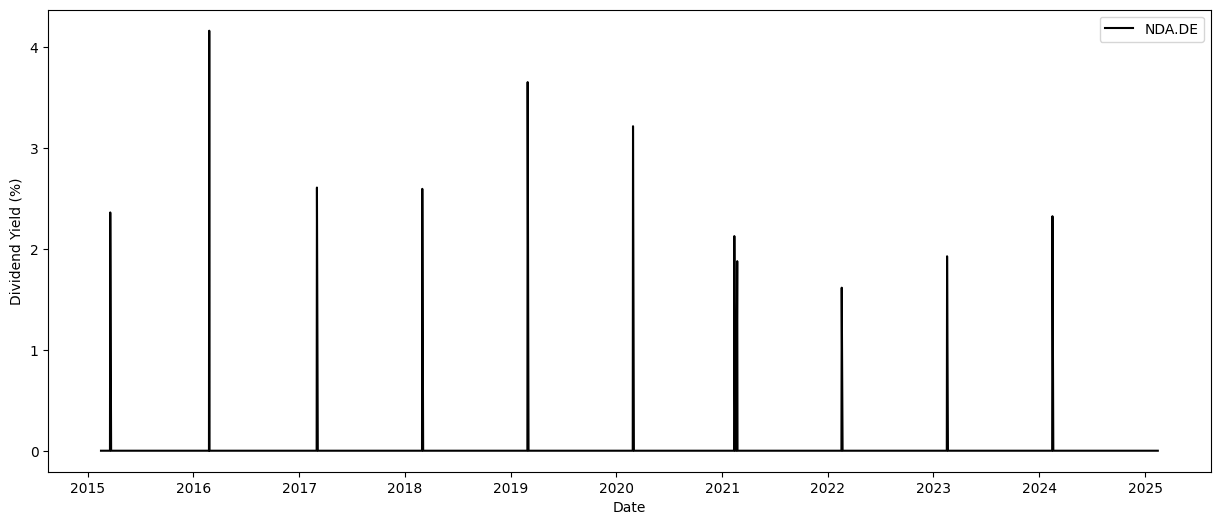

In [16]:
# get share prices and dividend yield data
ticker_all_price = utils.get_historical_share_dividend(share_name, merged_nat_curr)

currency_rate    0.071658
share_price      1.000000
Name: share_price, dtype: float64


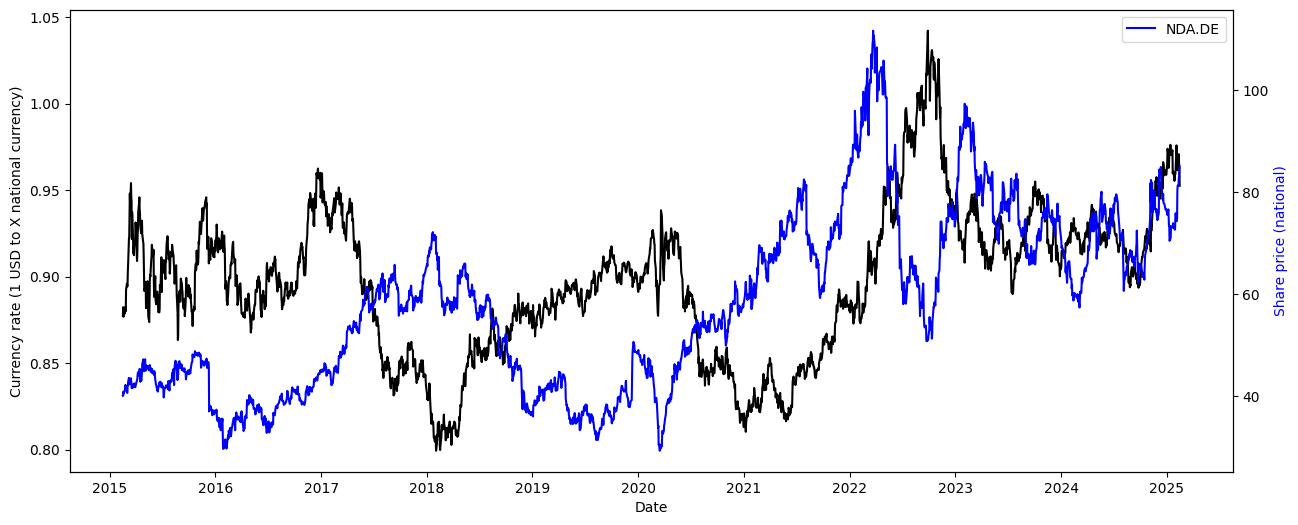

In [17]:
# Pearson's correlation coefficient between share price and USD - national currency rate
utils.get_currency_share_price_correlation(share_name, usd_nat_curr, ticker_all_price)

# Share price and value ratios

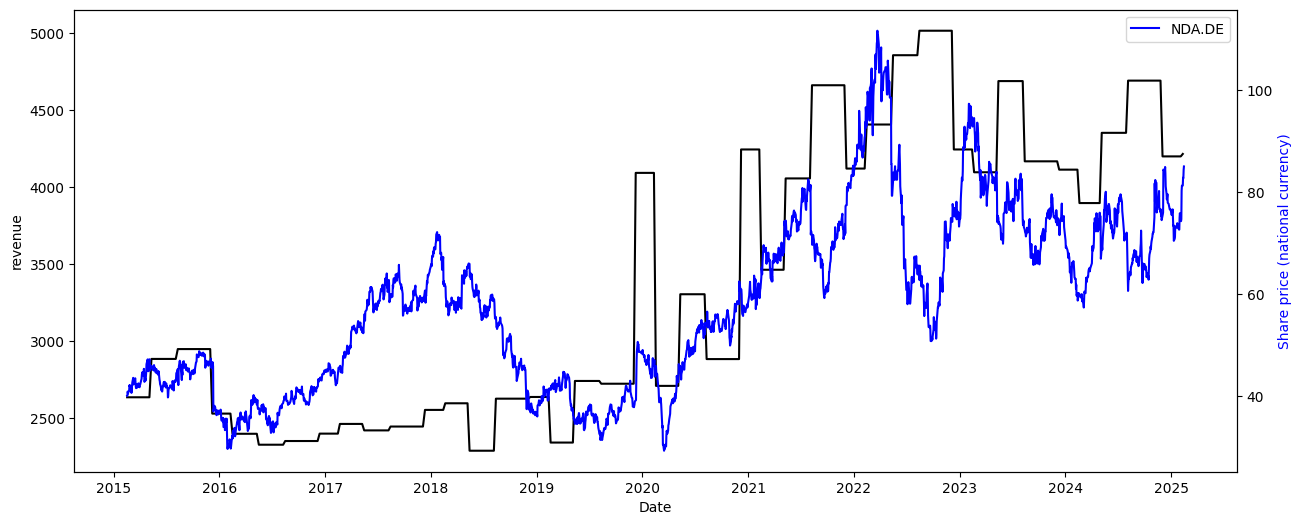

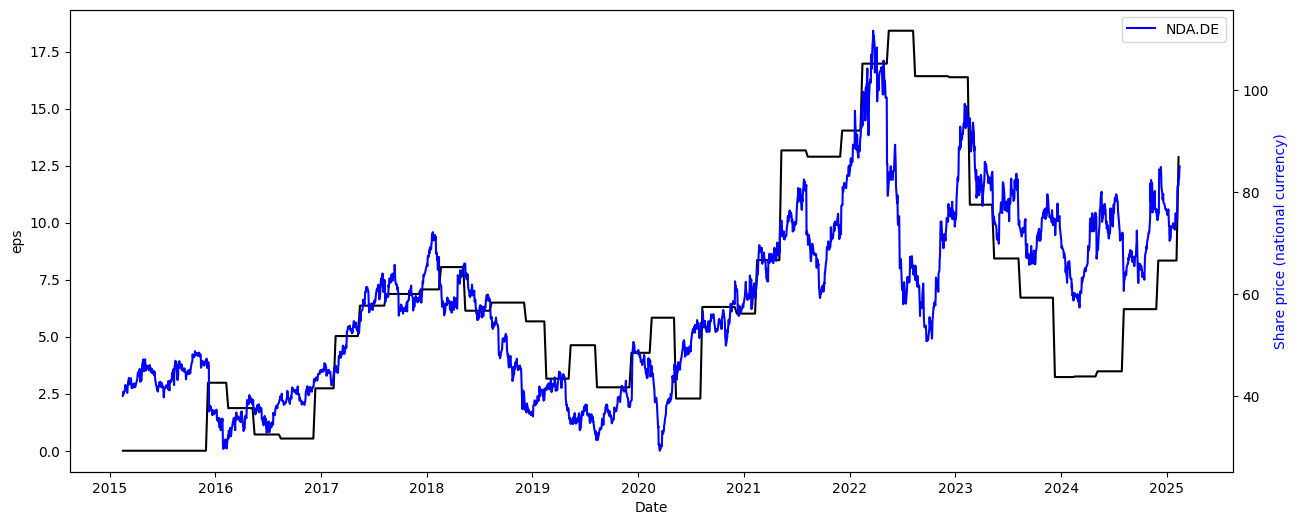

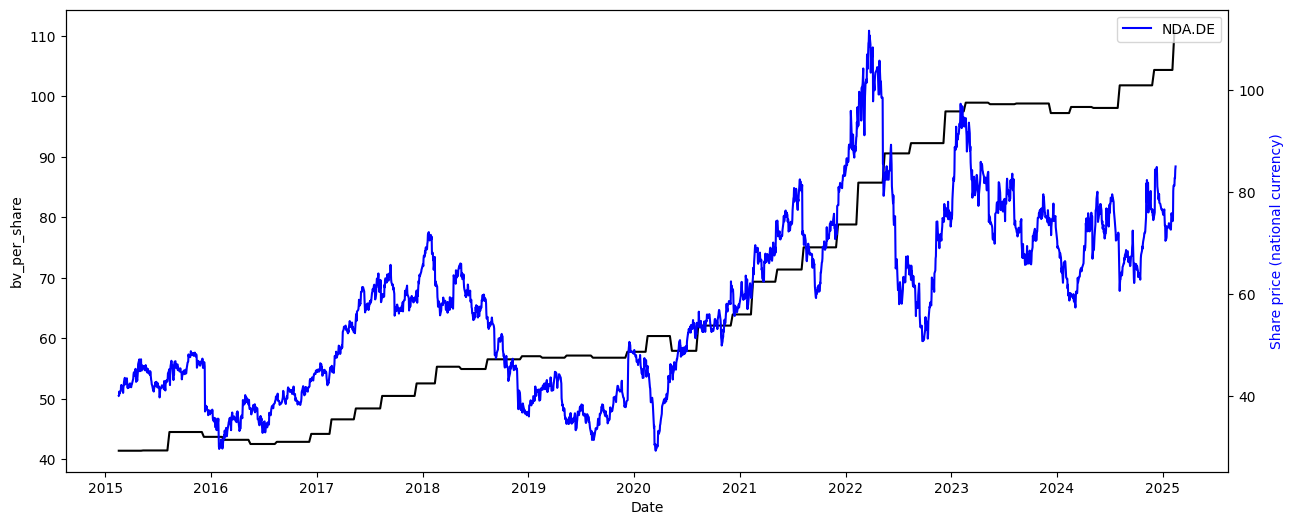

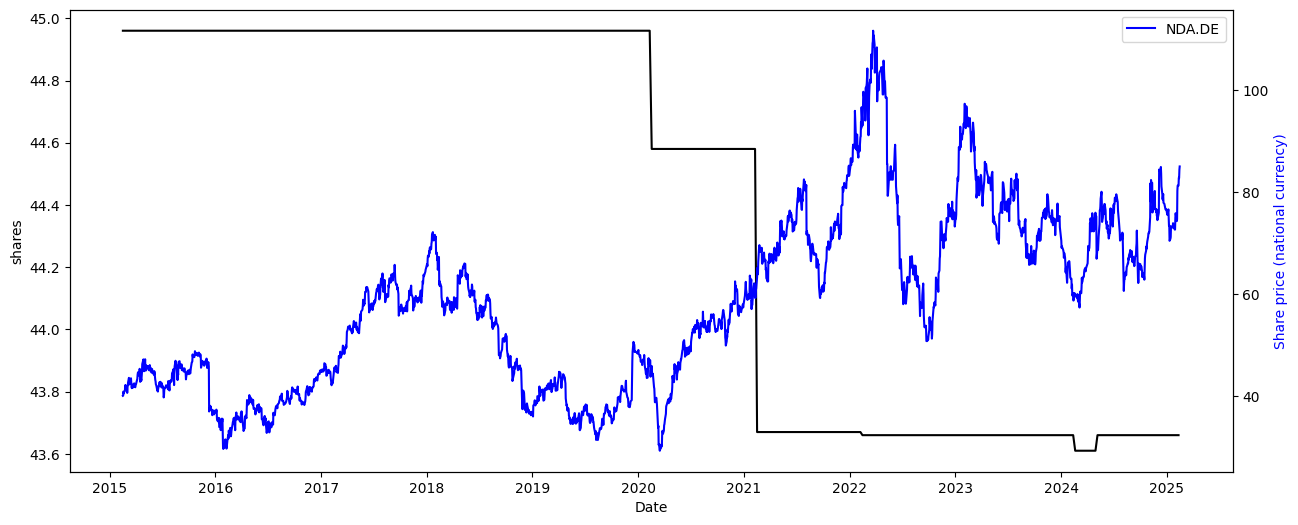

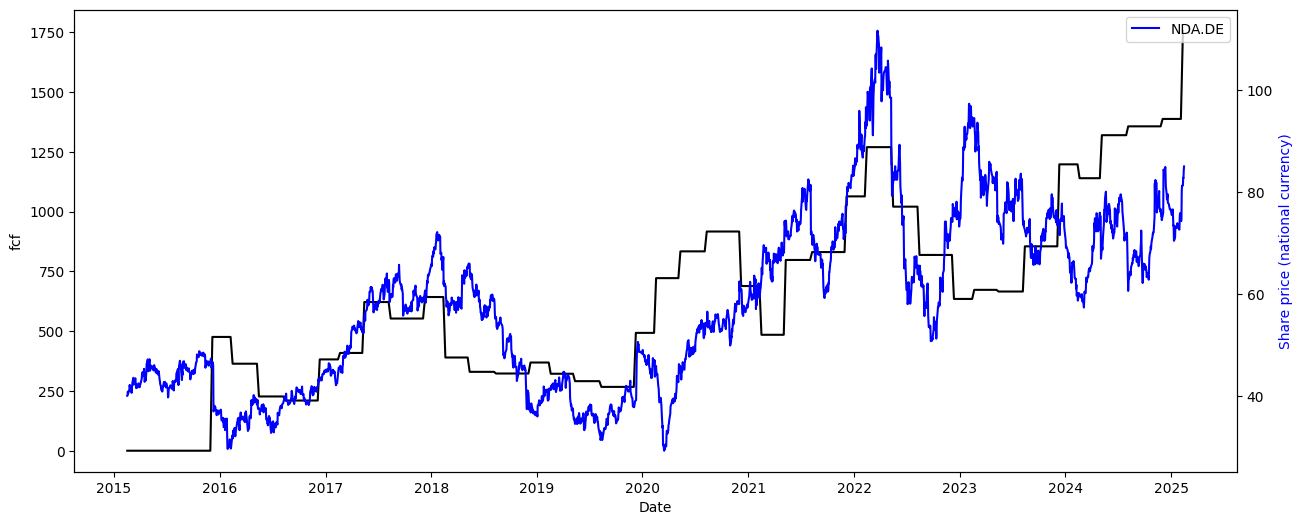

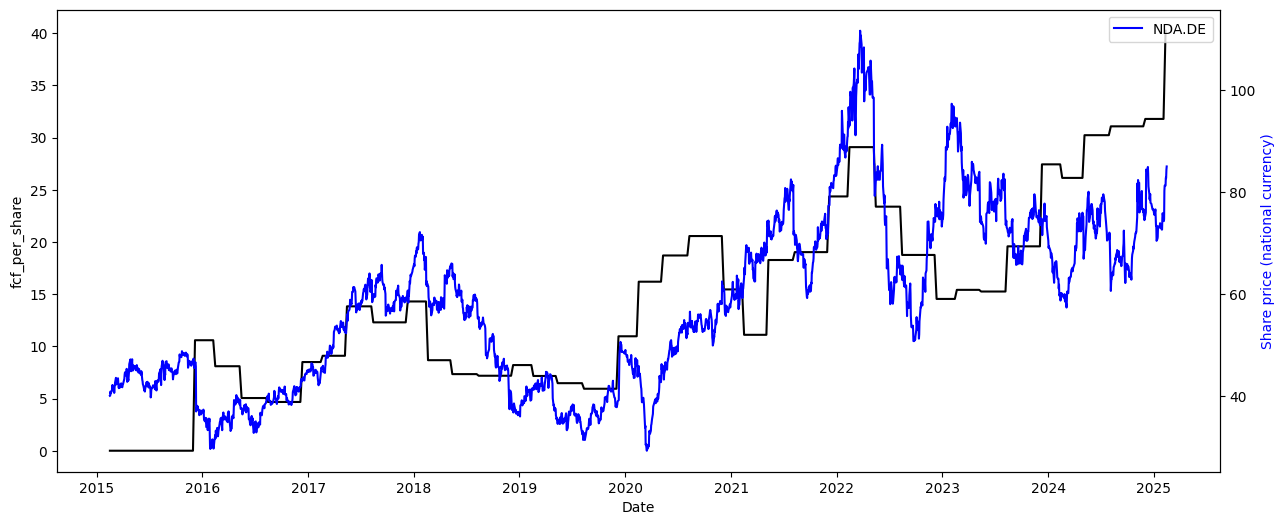

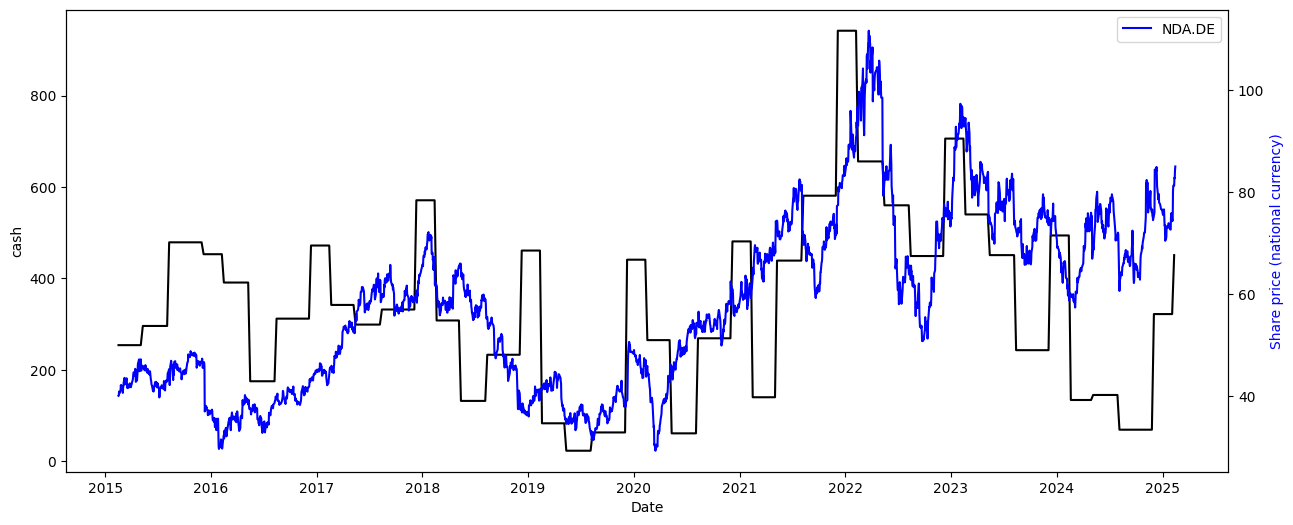

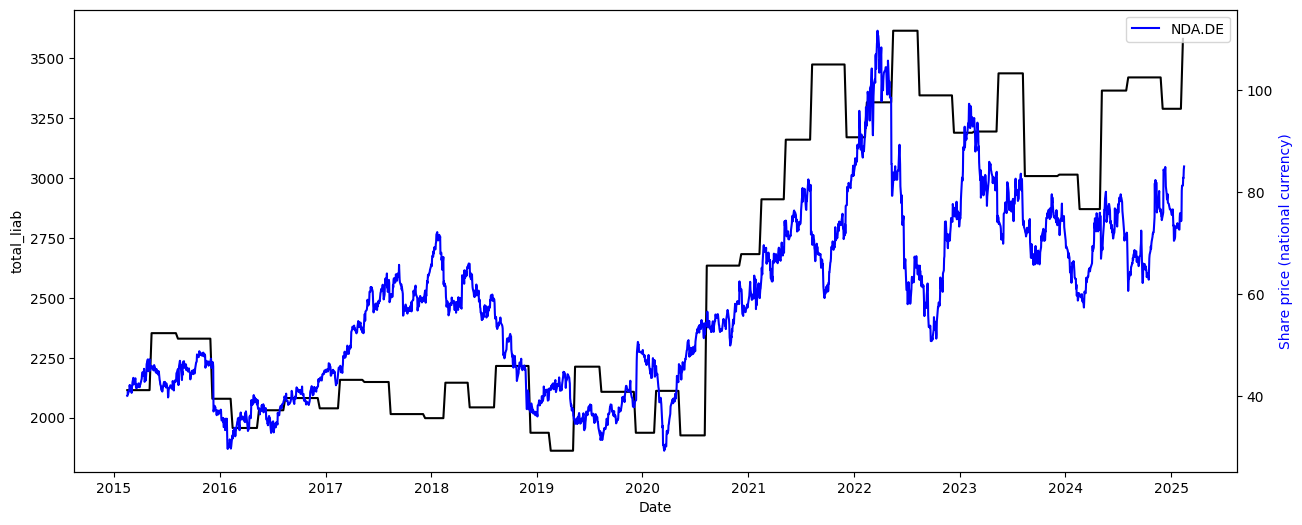

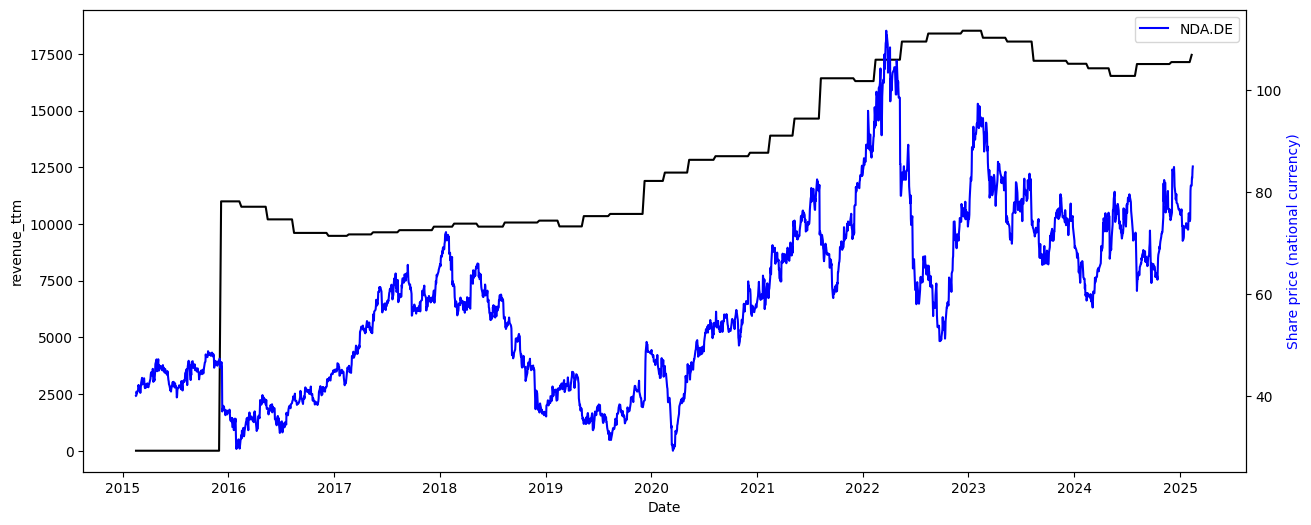

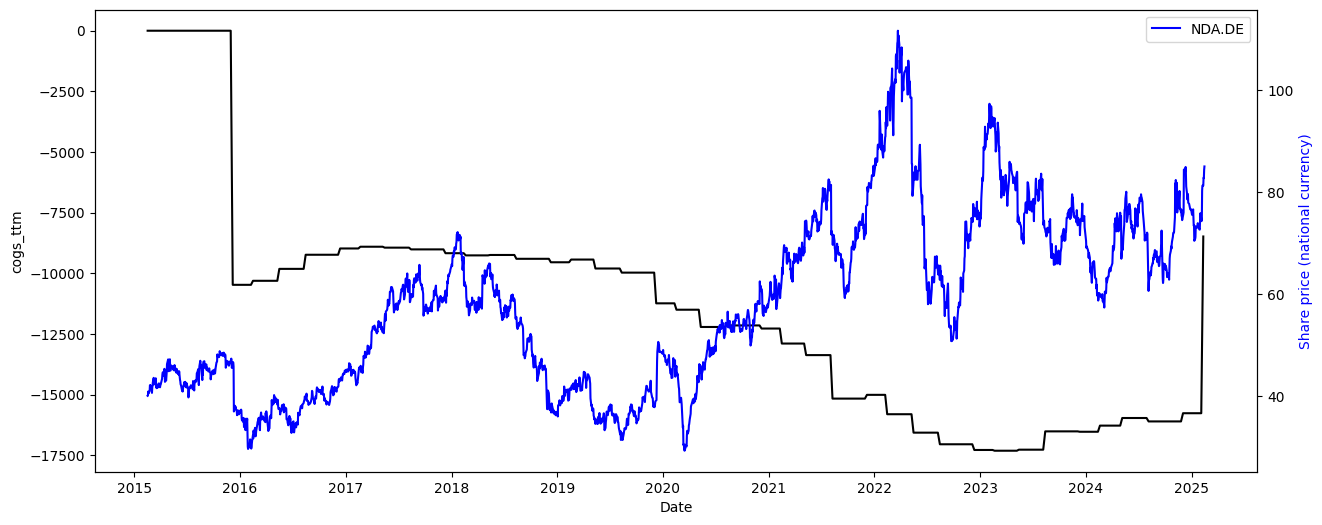

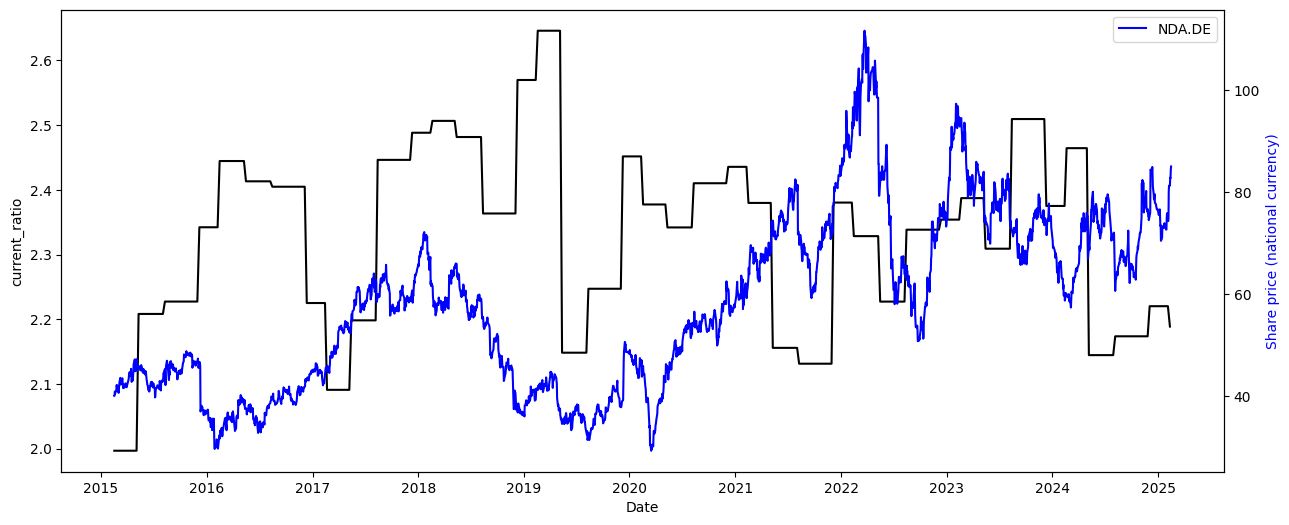

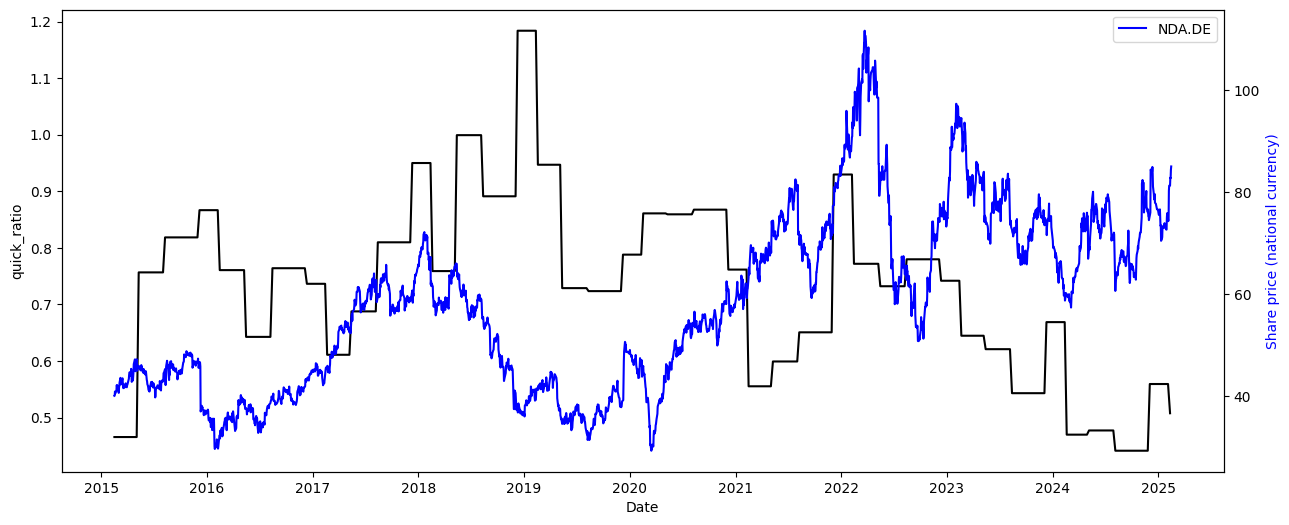

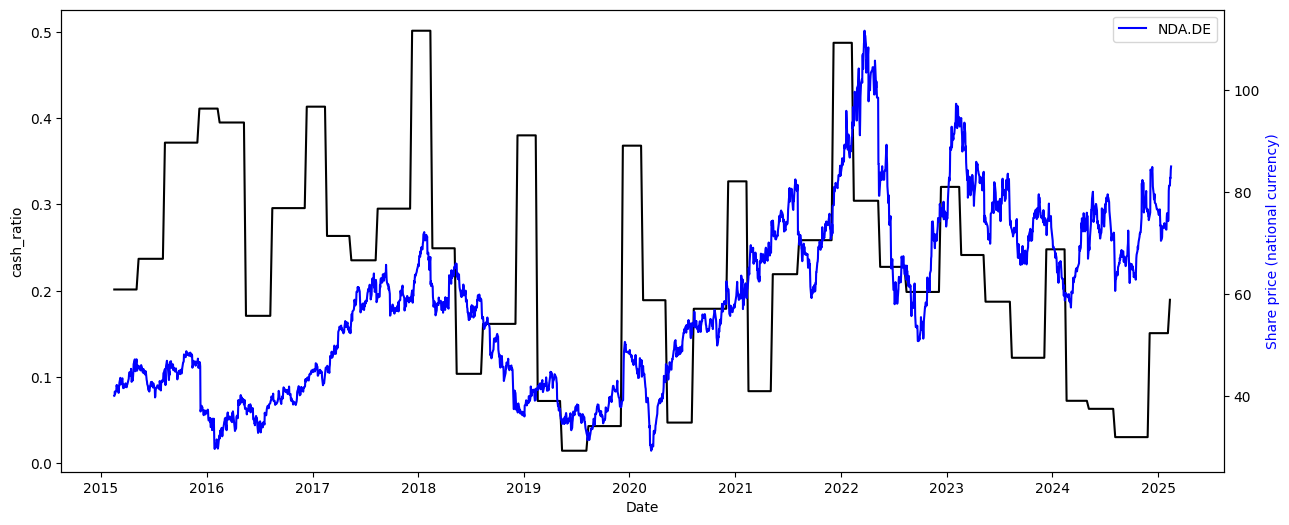

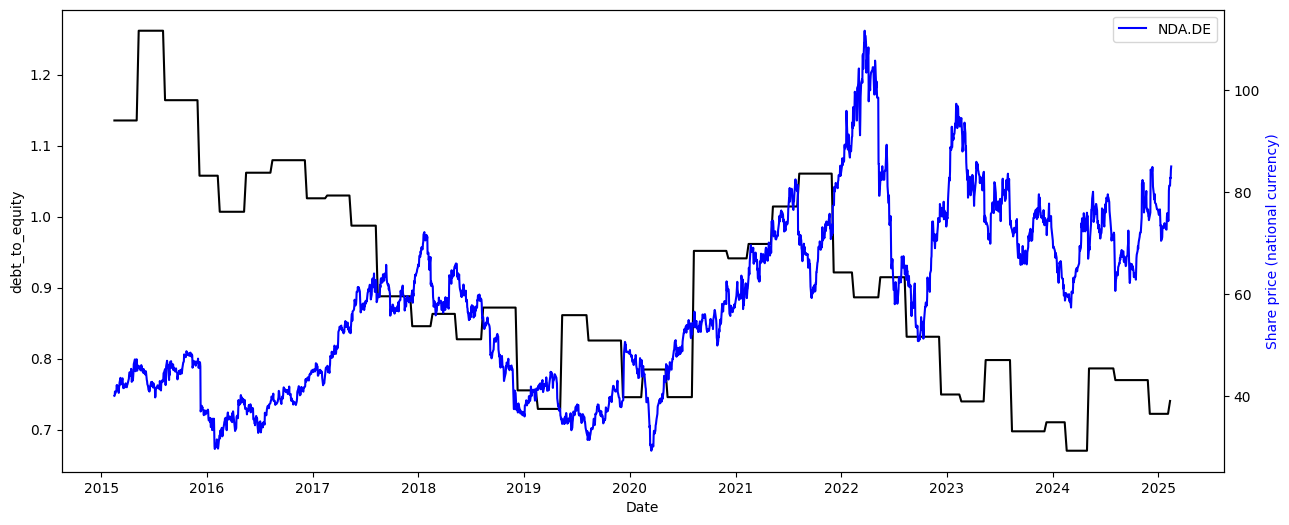

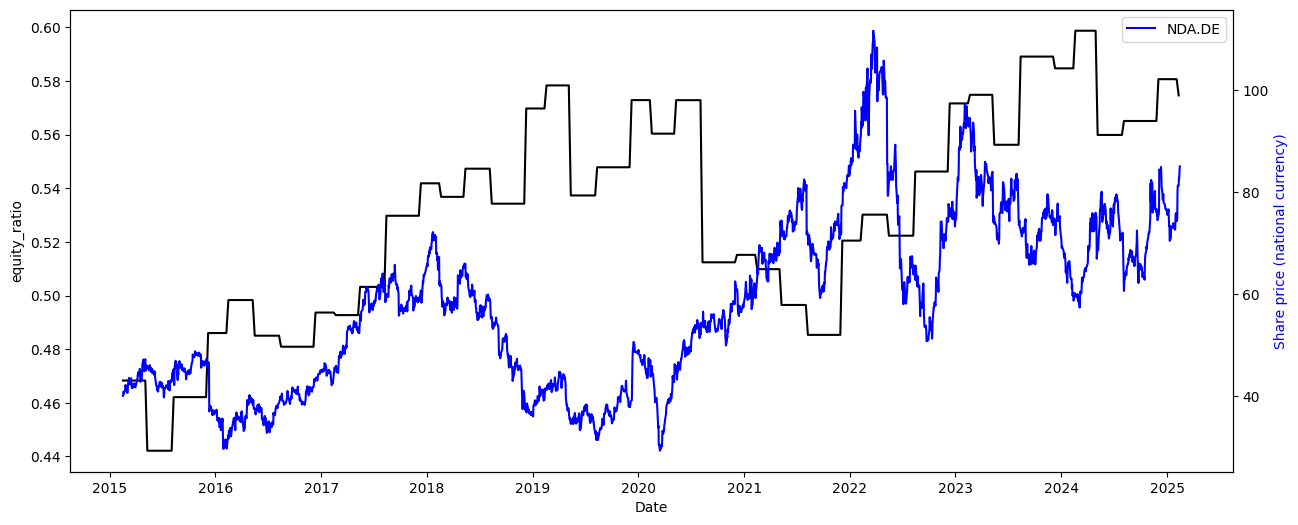

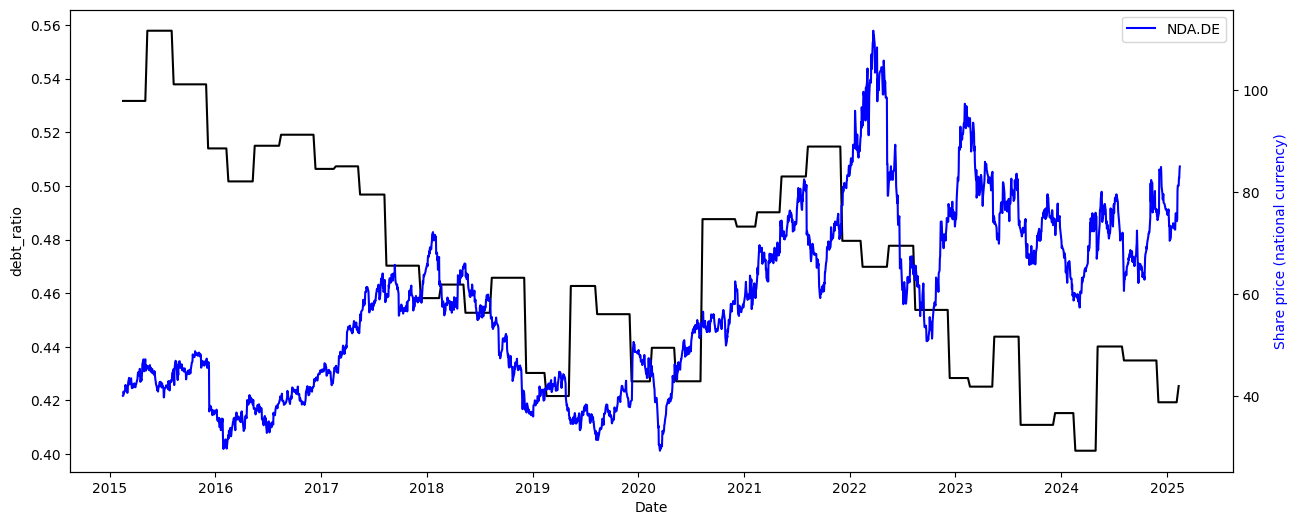

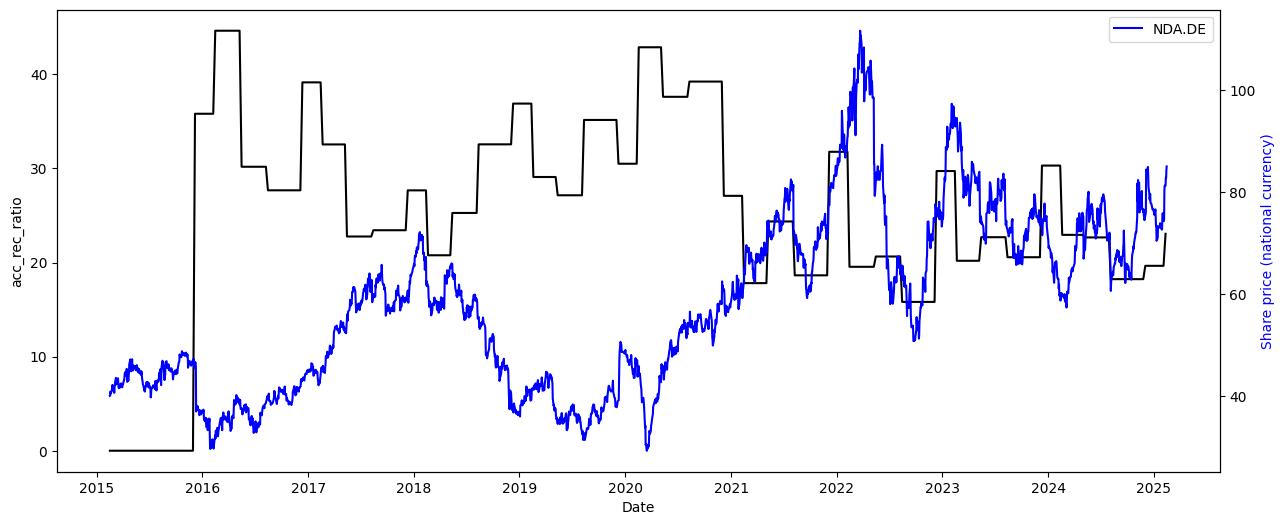

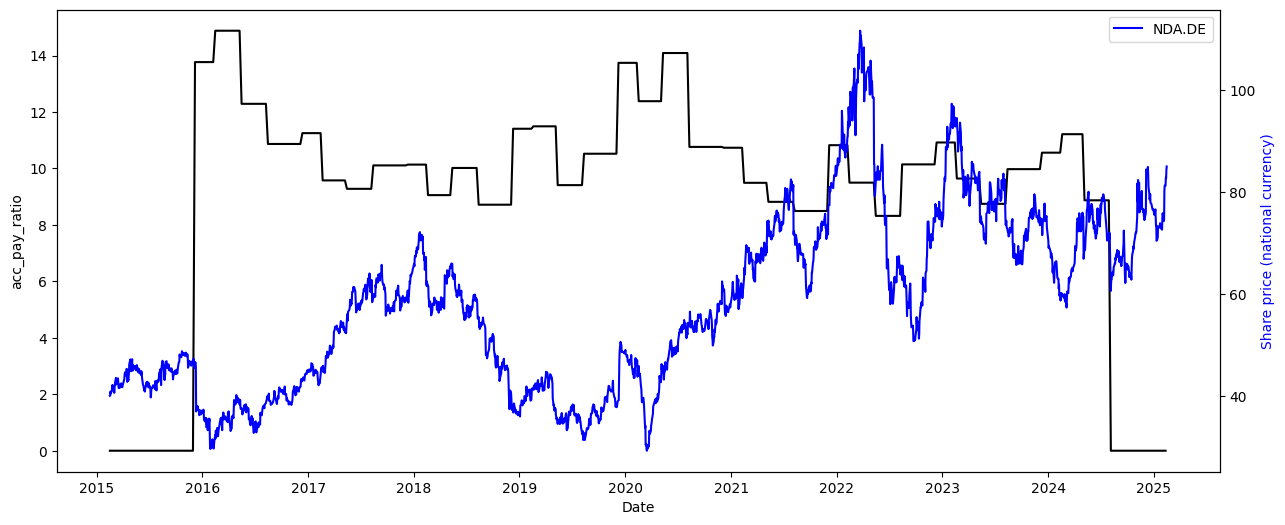

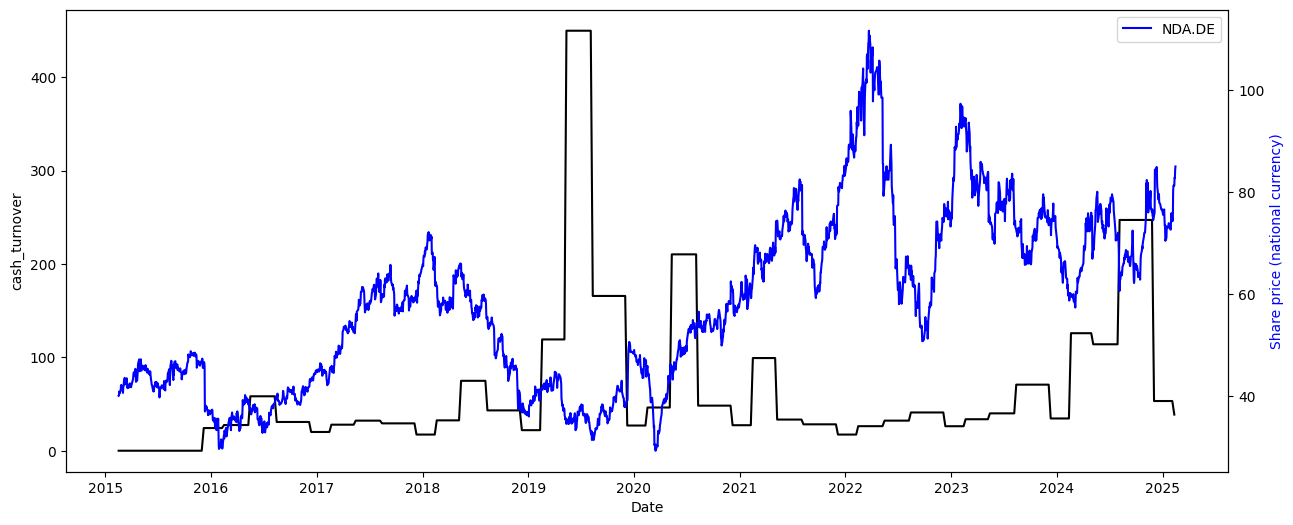

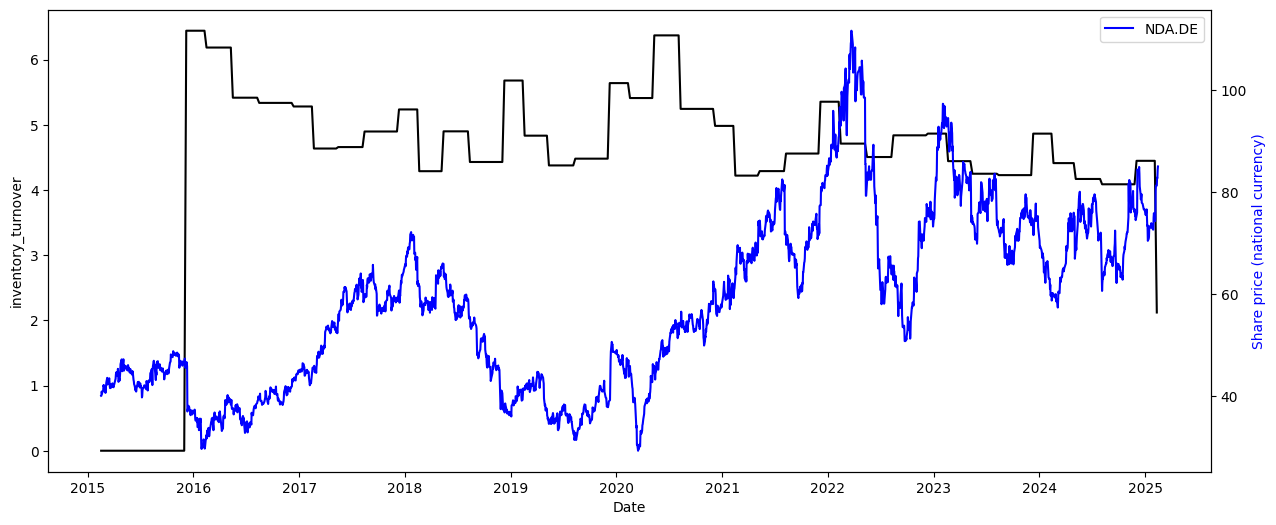

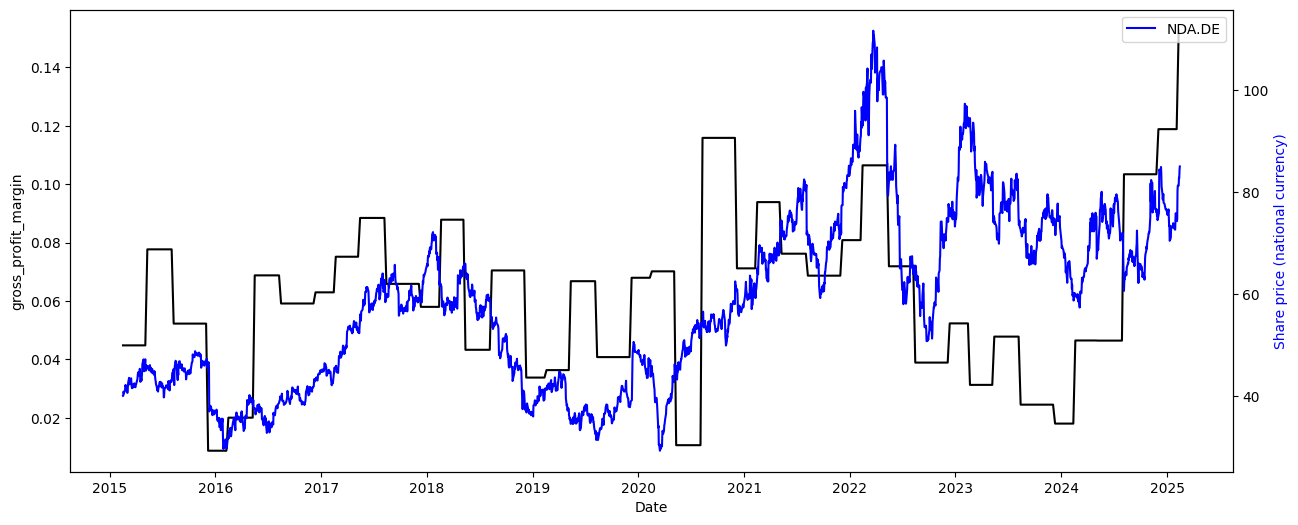

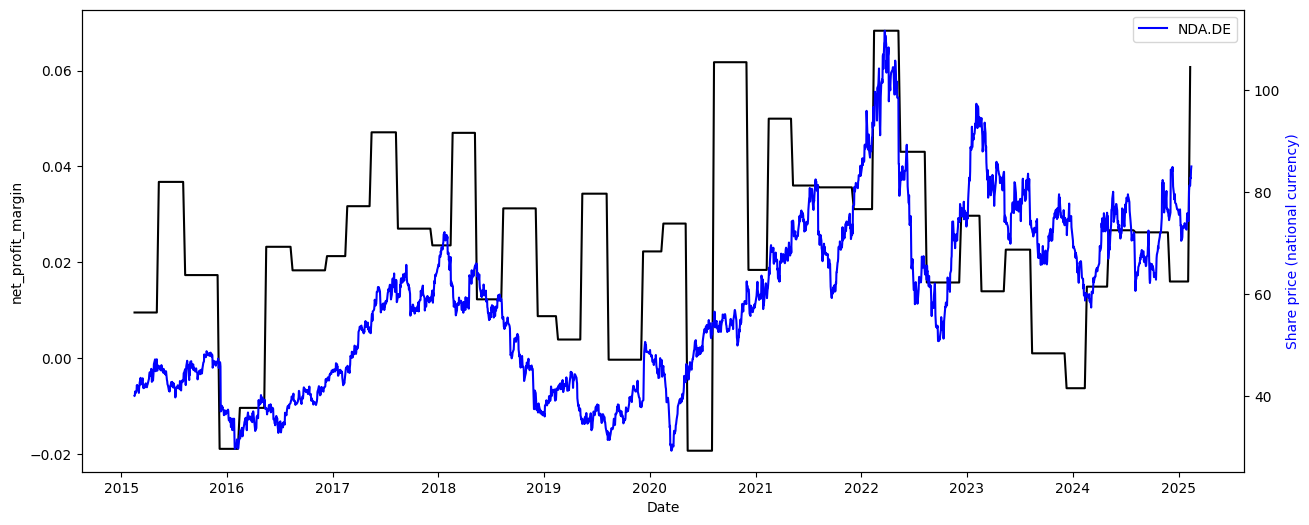

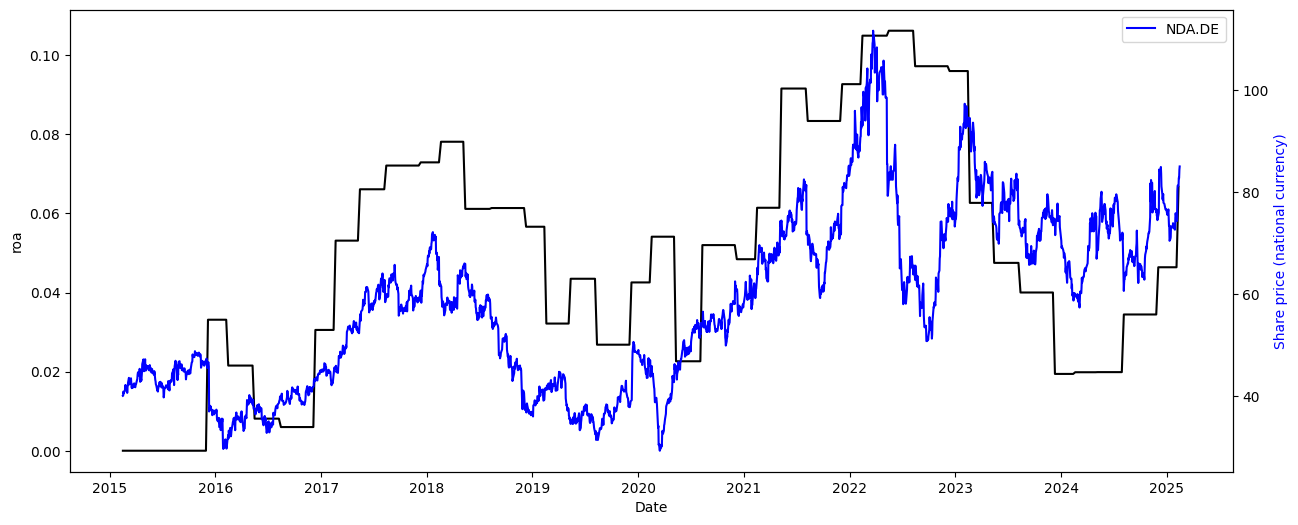

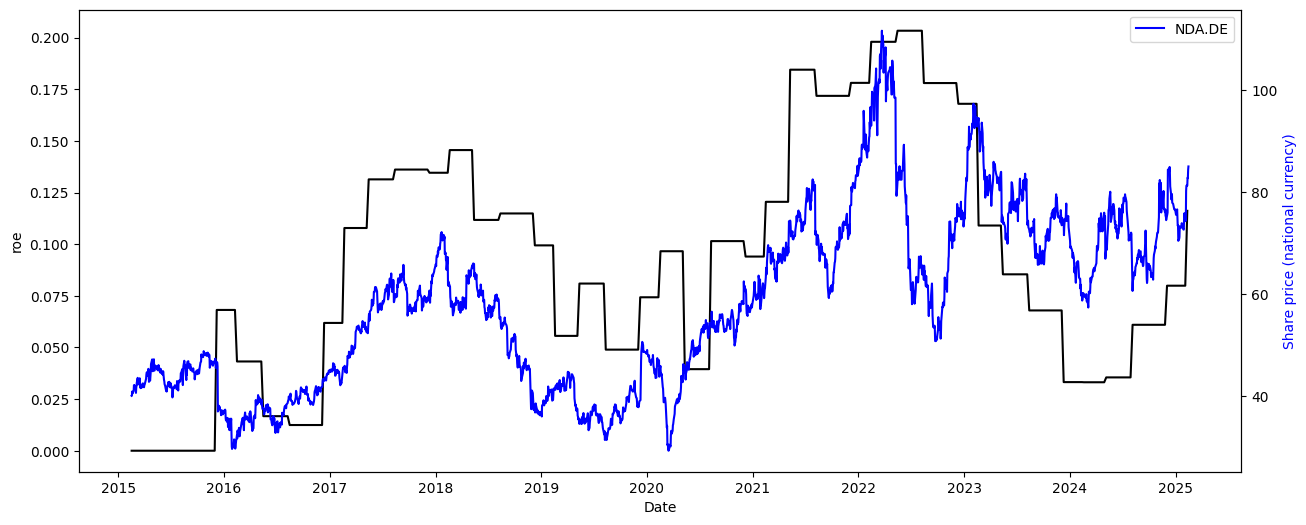

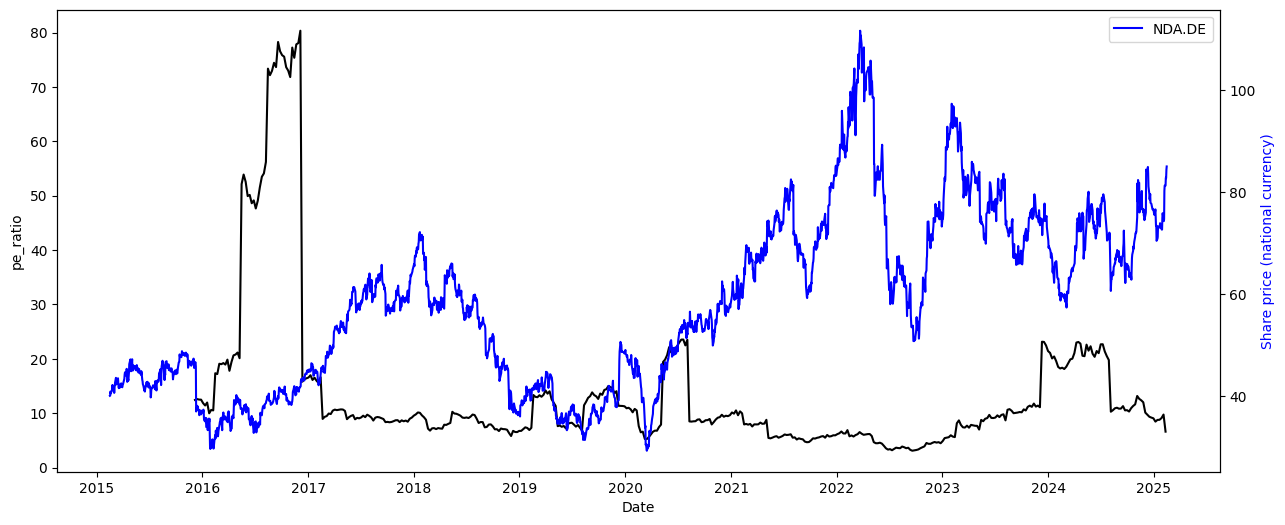

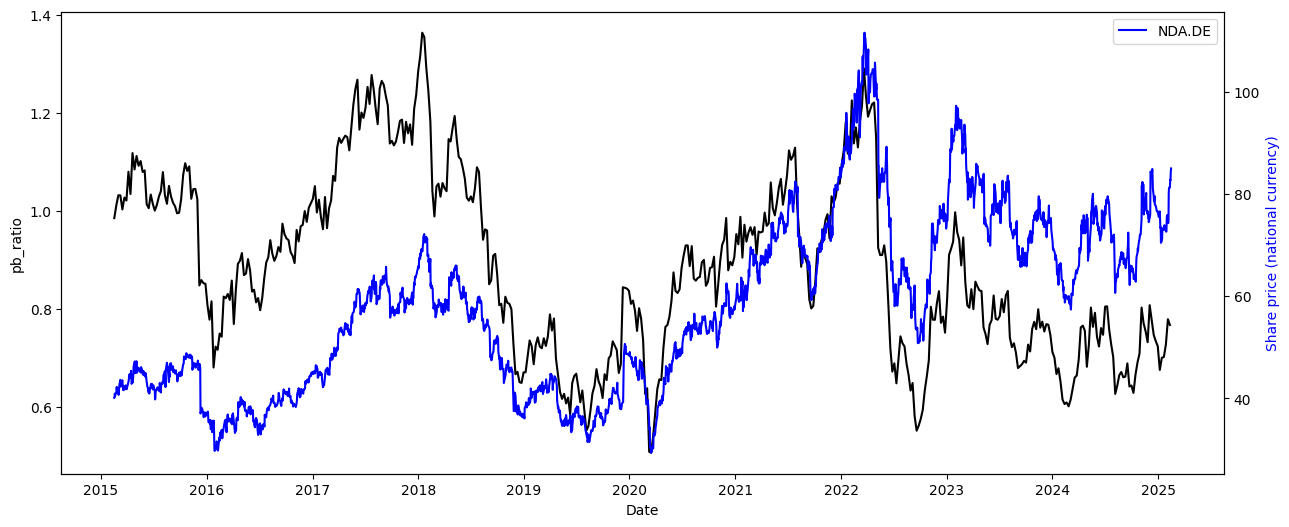

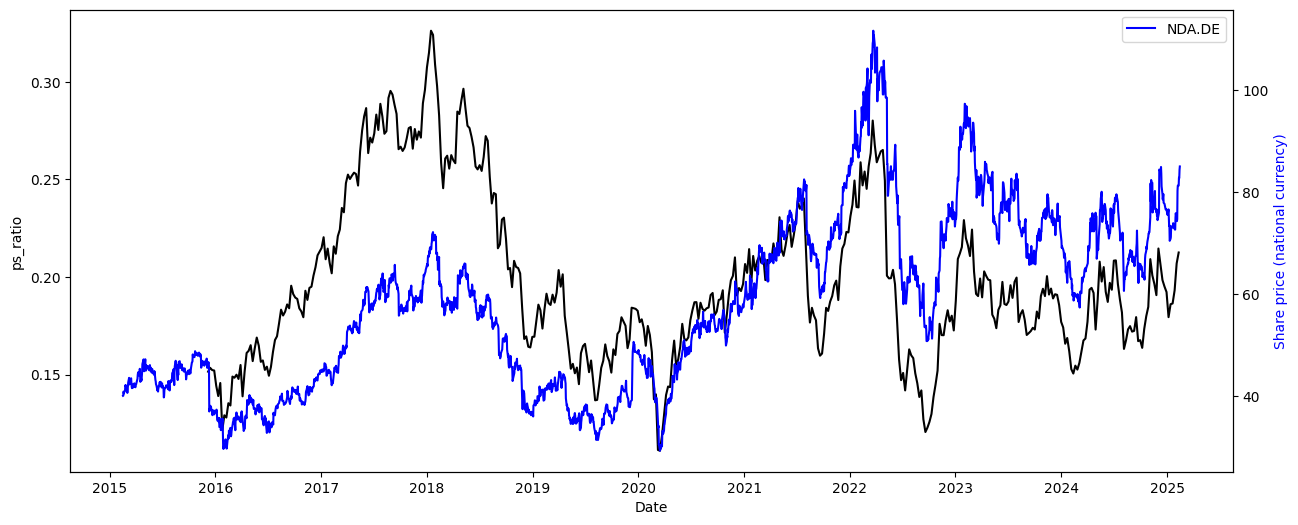

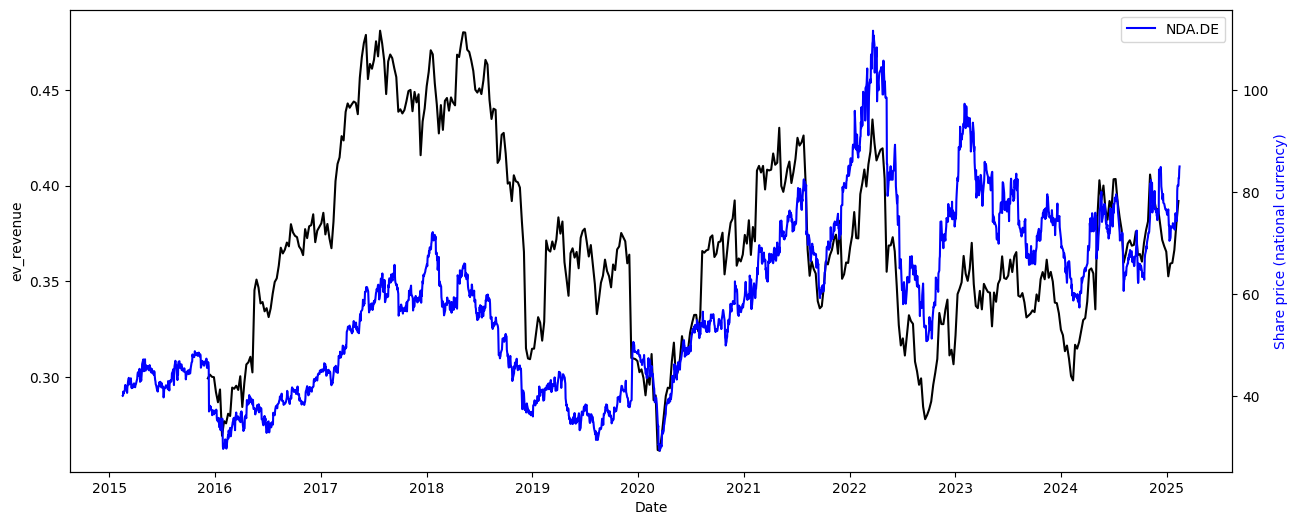

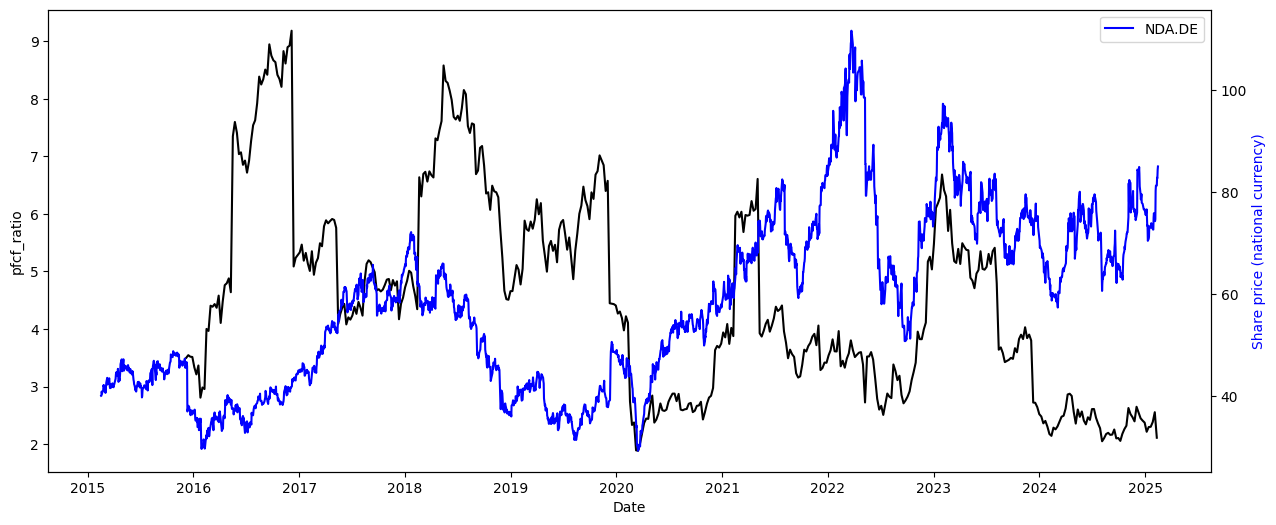

In [18]:
for column in merged_nat_curr.columns[3:]:
    fig, ax1 = plt.subplots(figsize=(15, 6))

    ax2 = ax1.twinx()
    ax1.plot(merged_nat_curr['real_date'], merged_nat_curr[column], color='k', label=merged_nat_curr)
    ax2.plot(ticker_all_price.index, ticker_all_price['Close'], color='b', label=share_name)

    ax1.set_xlabel('Date')
    ax1.set_ylabel(column, color='k')
    ax2.set_ylabel('Share price (national currency)', color='b')

    plt.legend()
    plt.show()

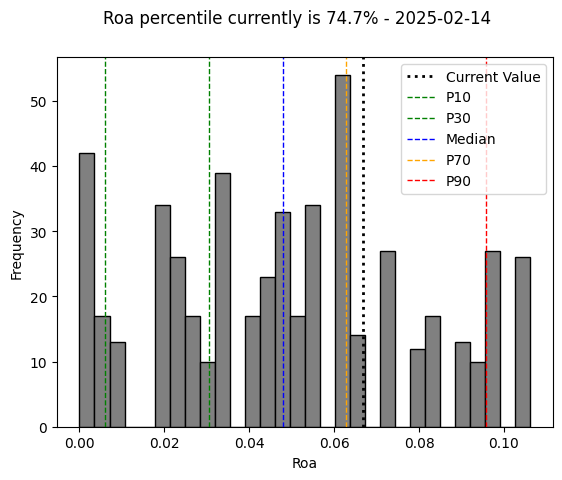

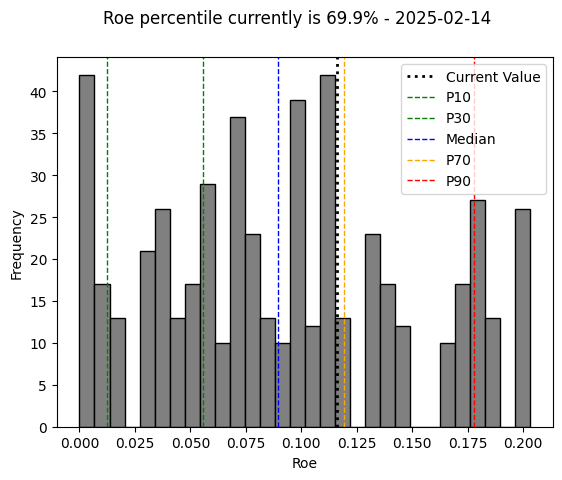

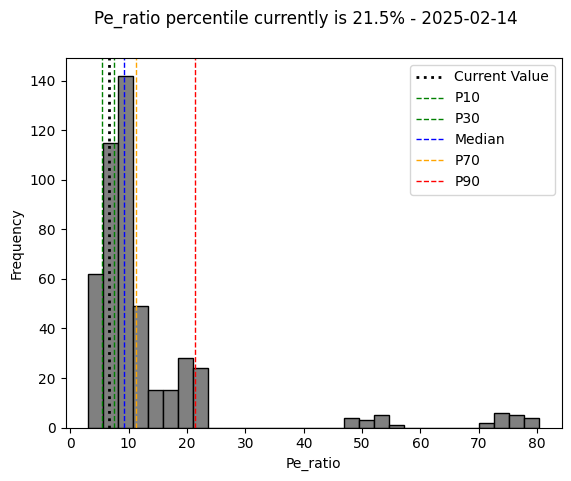

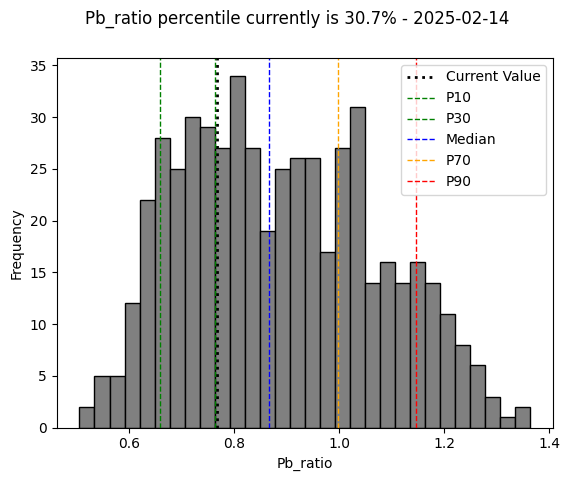

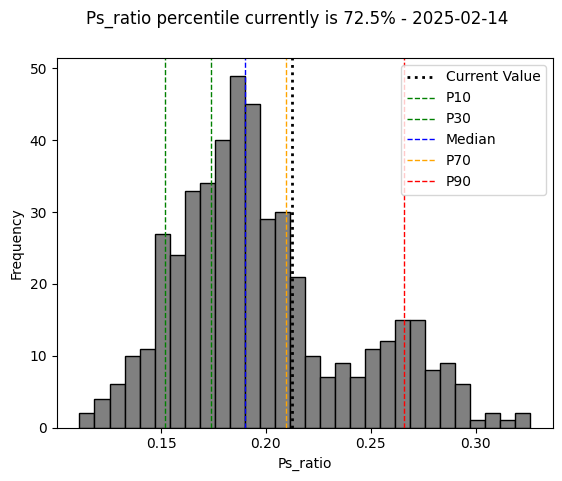

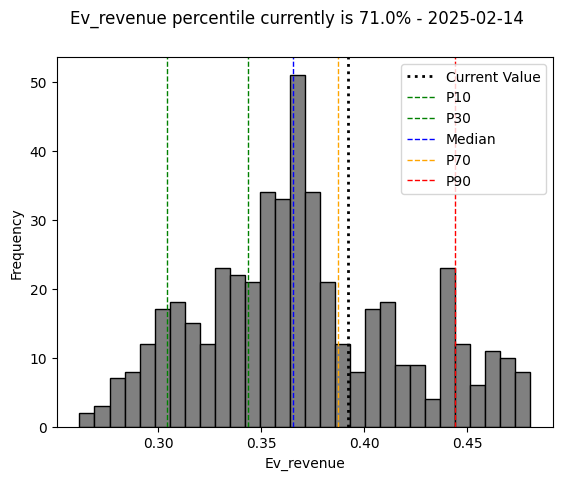

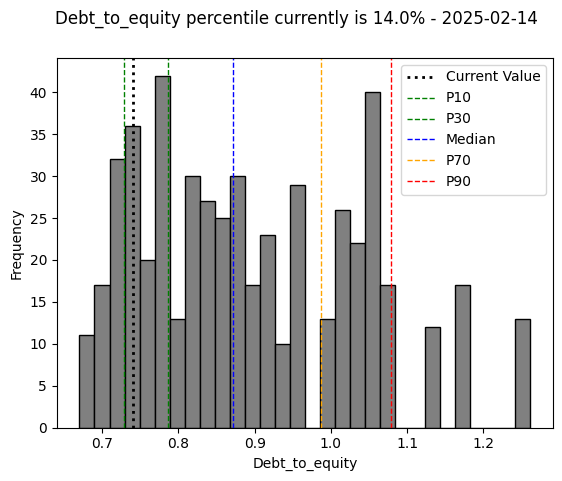

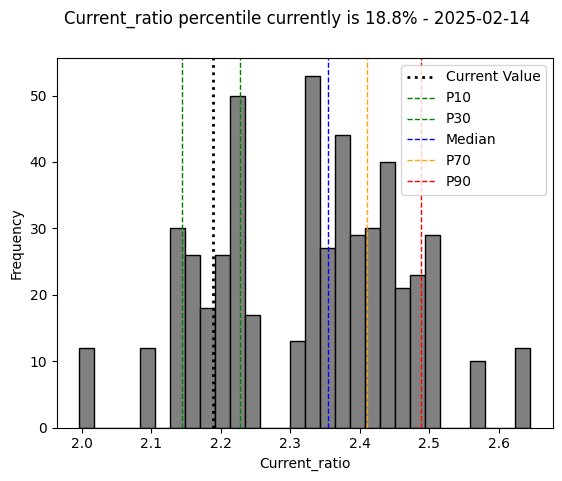

In [19]:
# plot histograms of value parameters
utils.plot_histogram_value_parameters(input_df=merged_nat_curr, extra_parameters=[], owned_shares=owned_shares)

## Calculate correlation between value parameters

In [20]:
# calulate value parameters Pearson's correlation coefficient
pd.DataFrame(merged_nat_curr, columns=['roa', 'roe', 'pe_ratio', 'pb_ratio', 'ps_ratio', 'ev_revenue', 'debt_to_equity', 'current_ratio']).corr()

,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,debt_to_equity,current_ratio
roa,1.000000,0.995530,-0.652385,0.199668,0.385015,0.261181,-0.239999,0.072335
roe,0.995530,1.000000,-0.634037,0.236093,0.393375,0.285313,-0.170827,0.030003
pe_ratio,-0.652385,-0.634037,1.000000,-0.004136,-0.154825,-0.082820,0.324137,0.136772
pb_ratio,0.199668,0.236093,-0.004136,1.000000,0.897674,0.767014,0.501954,-0.073983
ps_ratio,0.385015,0.393375,-0.154825,0.897674,1.000000,0.907626,0.121762,0.077835
ev_revenue,0.261181,0.285313,-0.082820,0.767014,0.907626,1.000000,0.219284,-0.103733
debt_to_equity,-0.239999,-0.170827,0.324137,0.501954,0.121762,0.219284,1.000000,-0.430073
current_ratio,0.072335,0.030003,0.136772,-0.073983,0.077835,-0.103733,-0.430073,1.000000


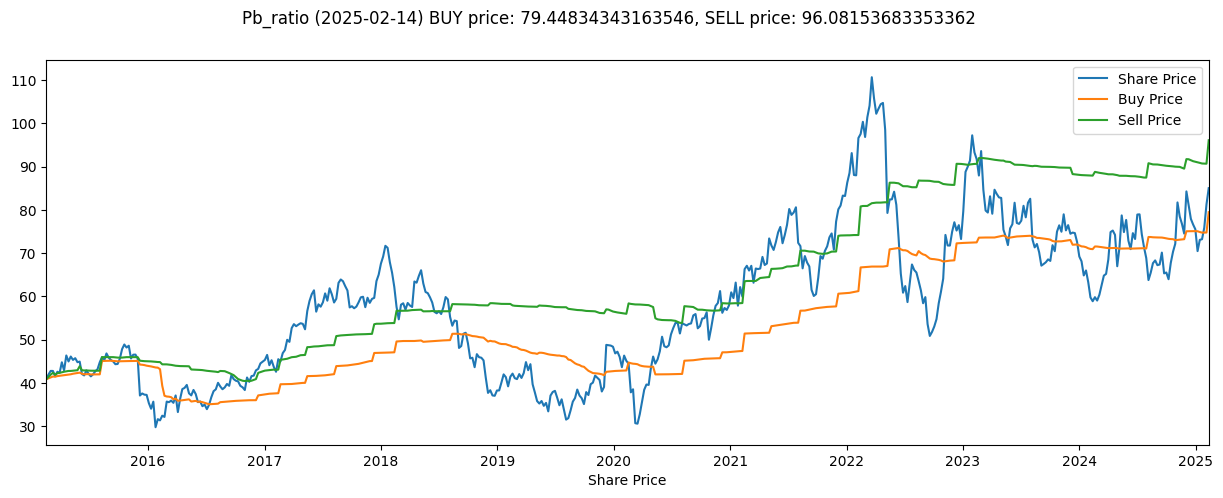

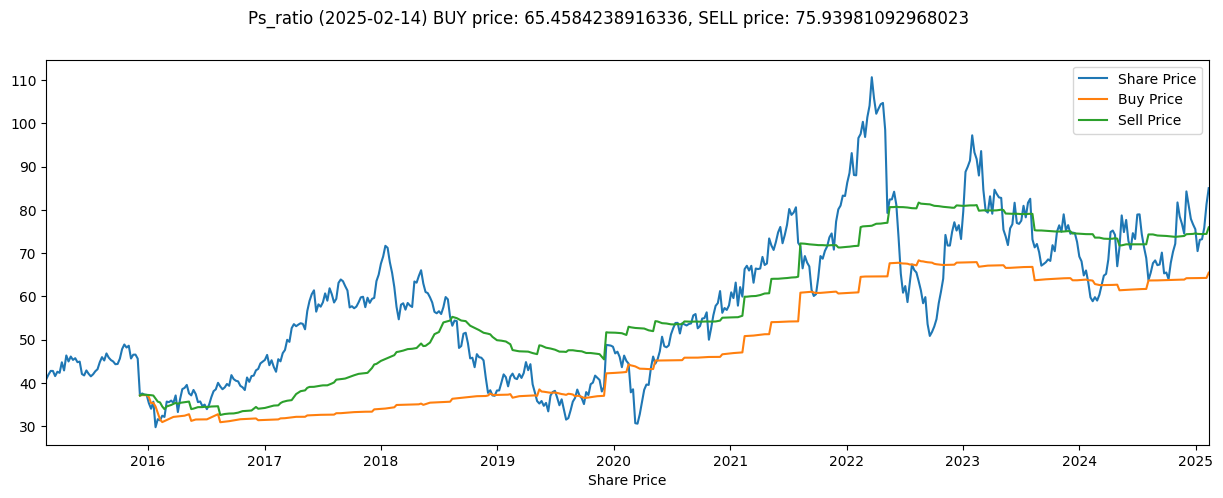

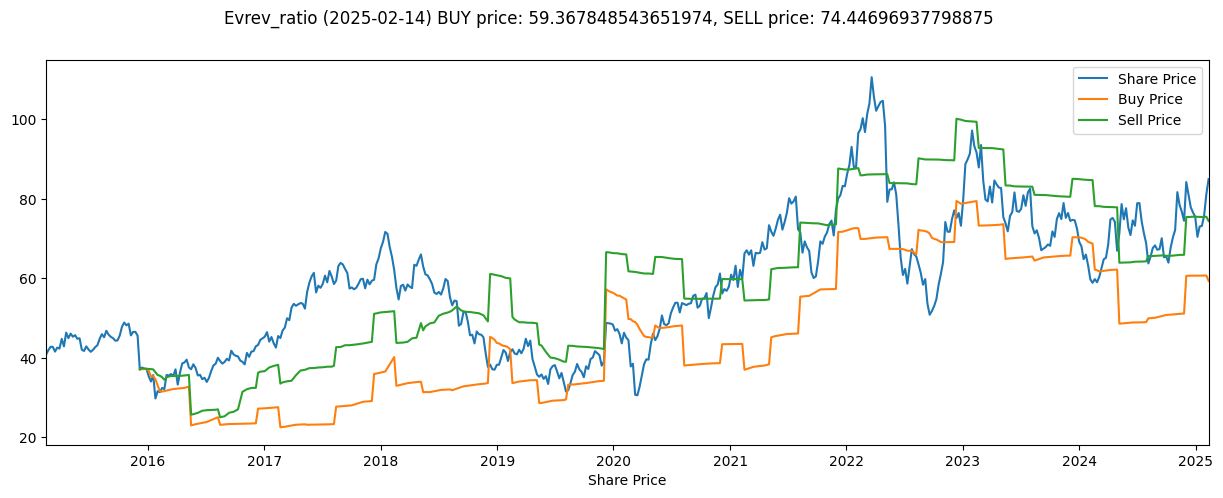

In [21]:
final_df = utils.get_value_stock_target_prices(
    input_df=merged_nat_curr,
    min_pct=0.2,
    max_pct=0.5,
    owned_shares=owned_shares
)